# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [130]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# TODO: Agregar las librerías que hagan falta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve,auc


from IPython.display import Image
from IPython.core.display import HTML


# Funciones

In [185]:
def plot_roc_auc(actual, preds,optimal_tpr,optimal_fpr):
    
    fig,axs=plt.subplots(nrows=1,ncols=2,sharex=False,figsize=(10,5))
    
    fpr, tpr, thresholds = roc_curve(actual, preds)
    roc_auc = auc(fpr, tpr)
    axs[0].plot(fpr, tpr,'r')
    axs[0].plot([0,1],[0,1],'b')
    axs[0].set_title('AUC: {}'.format(roc_auc))
    axs[0].set_xlabel('FPR')
    axs[0].set_ylabel('TPR')
    axs[0].hlines(y=optimal_tpr,color='g',xmin=0,xmax=1,linestyles='dotted')
    axs[0].vlines(x=optimal_fpr,color='g',ymin=0,ymax=1,linestyles='dotted')
    
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
    roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    
    # Plot tpr vs 1-fpr
    axs[1].plot(roc['tpr'])
    axs[1].plot(roc['1-fpr'], color = 'red')
    axs[1].set_xlabel('1-FPR')
    axs[1].set_ylabel('TPR')
    axs[1].set_title('Receiver operating characteristic')
    axs[1].set_xticklabels([])
    plt.show()

In [172]:
def encontrar_punto_corte_roc(target, predicted):
    
    """ Función que encuentra el punto óptimo de corte en la curva roc utilizando el índice de Youden
    
    https://es.wikipedia.org/wiki/%C3%8Dndice_de_Youden
    ----------
    target : y_test

    predicted : predicciones

    Returns
    -------     
    cut-off value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tpr': pd.Series(tpr),
                        'fpr' : pd.Series(fpr),
                        'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t=roc.iloc[(roc.tf-0).abs().argsort()][:1]

    return list(roc_t['threshold']),roc


## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [109]:
dataset = pd.read_csv("../data/loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

In [110]:
dataset.head()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


In [111]:
dataset.TARGET.value_counts()

0    1545
1     309
Name: TARGET, dtype: int64

1) Los datos están estructurados en una serie de variables obtenidas de clientes del departamento de créditos de un banco. Proporcionan datos relevantes sobre el desempeño de 5960 préstamos con garantía hipotecaria, categorizando los mismos según hayan caído en default o no. 

2) La variable objetivo a predecir `TARGET` es binaria y etiqueta aquellos prestamos que han sido pagados y los que no(default). El valor 0 se corresponde con aquellos que han pagado el préstamo, mientras que si toma valor 1 es porque han incumplido.

3) Para cada solicitante de préstamo se registraron 12 variables de entrada o atributos que se mencionan a continuación.

  
 `LOAN`: Monto de la solicitud de préstamo
 
 `MORTDUE`: Monto adeudado de la hipoteca existente
 
 `VALUE`: Valor de la propiedad actual
 
 `YOJ`: Años en el trabajo actual
 
 `DEROG`: Número de informes importantes derogados 
 
 `DELINQ`: Número de líneas de crédito morosas
 
 `CLAGE`: Antigüedad de la línea comercial más antigua en meses
 
 `NINQ`: Número de líneas de crédito recientes
 
 `CLNO`: Número de líneas de crédito
 
`DEBTINC`: Relación deuda-ingresos

4) Los atributos más determinantes para la predicción son: `LOAN`,  `MORTDUE`, `DELINQ` y `DEBTINC`


## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


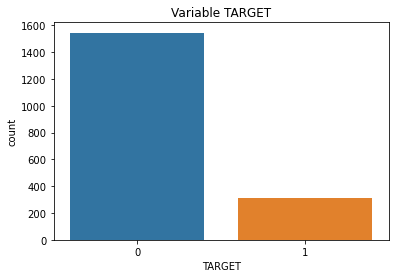

In [112]:
sns.countplot(dataset.TARGET)
plt.title("Variable TARGET")
plt.show()                      #Hay 309 créditos en default

La variable objetivo esta muy desbalanceada, por encontrarse la mayor proporción de los créditos en el grupo de aquellos que no entraron en default.

Si medimos la efectividad de nuestro modelo por la cantidad de aciertos que tuvo, sólo teniendo en cuenta a la clase mayoritaria podemos estar teniendo una falsa sensación de que el modelo funciona bien.

En este caso práctico, luego de hacer una evaluación de los riesgos que se deben asumir, lo que se buscaría evitar son los Falsos Negativos, es decir, que el modelo prediga que el cliente va a pagar el préstamo siendo que en realidad caerá en default. Debido a la relación dual entre presición y recall, podemos ubicarnos en un punto de la curva ROC que nos permita optimizar los resultados buscados.

#### Ajustamos el modelo

SGDC es altamente sensible a la escala de las variables, por lo cual un paso fundamental antes de definir y entrenar el modelo es el escalamiento.

Al tener algunas variables booleanas (DEROG, DELINQ), es mejor utilizar MinMaxScaler para llevar todas las variables al rango (0,1)

In [113]:
scaler=MinMaxScaler()
sgd=SGDClassifier(random_state=0)

model = make_pipeline(scaler,sgd)
model.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('sgdclassifier', SGDClassifier(random_state=0))])

#### Predecimos y obtenermos las métricas

In [114]:
y_train_pred= model.predict(X_train)
y_test_pred= model.predict(X_test)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("TESTEO")
print(classification_report(y_test, y_test_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1232
           1       0.80      0.34      0.48       251

    accuracy                           0.87      1483
   macro avg       0.84      0.66      0.70      1483
weighted avg       0.87      0.87      0.85      1483

TESTEO
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       313
           1       0.74      0.34      0.47        58

    accuracy                           0.88       371
   macro avg       0.82      0.66      0.70       371
weighted avg       0.87      0.88      0.86       371



Estamos en un caso de alta precisión y bajo recall para la clase 1, es decir que el modelo no detecta la clase muy bien pero cuando lo hace es altamente confiable. Esto también se verá en la matriz de confusión a continuación

5. Matriz de confusión

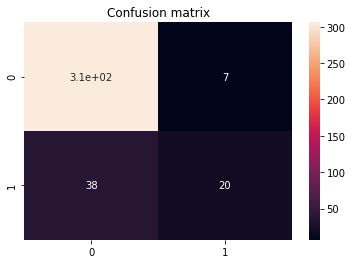

In [115]:
#Testeo

cm=confusion_matrix(y_test,y_test_pred)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")     
plt.show()
#El objetivo en las matrices de confusión es maximizar los casos en la diagonal principal, que implica que tenés casos correctamente clasificados

Como dijimos anteriormente, el modelo predice correctamente la clase 0 pero no la clase 1. Esto es debido al alto grado de desbalanceo en la variable objetivo.

Para este tipo de situaciones con alto desbalanceo en las clases de la variable objetivo, se pueden plantear diferentes soluciones, tales como:

1)Ajustar los parámetros del modelo utilizando "class_weight" para intentar equilibrar la clase minoritaria penalizando la mayoritaria.

2)Oversampling de la clase minoritaria utilizando diferentes metodologías como RandomVerSampler o SMOTE.

3) Undersampling de la clase mayoritaria.

4) Ensamble de modelos con balanceo.

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### Definimos una grilla de parámetros

In [116]:
params={'sgd__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
        'sgd__alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'sgd__penalty':['l1','l2']}

Hacemos la validación cruzada con el modelo de descenso de gradiente y la grilla de hiperparámetros que queremos probar.

Usaremos el parámetro "class_weight" de SGDClassifier para equilibrar la clase minoritaria durante el entrenamiento. 

Asimismo, cambiaremos la métrica seleccionada por defecto (accuracy) para minimizar la función de pérdida. Como dijimos anteriormente, al tener un alto grado de desbalanceo en la variable objetivo, el accuracy no es la mejor métrica para ver la performance del modelo. Eligiremos entonces "balanced accuracy score". F1 o accuracy pueden sesgar el modelo hacia la clase mayoritaria en este tipo de casos en los cuales el dataset esta muy desbalanceado.

Empíricamente, encontramos que SGD converge después de observar aproximadamente 10 ^ 6 muestras de entrenamiento. Por lo tanto, una primera estimación razonable del número de iteraciones es max_iter = np.ceil (10 ** 6 / n), donde n es el tamaño del conjunto de entrenamiento.

https://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use

In [117]:
max_iter=np.ceil(10**6 / X_train.shape[0])

In [118]:
scaler=MinMaxScaler()
sgd= SGDClassifier(random_state=0,class_weight='balanced',max_iter=max_iter)

pipe = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])

cv = GridSearchCV(pipe, params, scoring='balanced_accuracy', cv=5,refit=True,n_jobs=-1)     
cv.fit(X_train, y_train);

In [119]:
results = cv.cv_results_

In [120]:
df = pd.DataFrame(results)
df=df[['param_sgd__loss', 'param_sgd__alpha','param_sgd__penalty','mean_test_score', 'std_test_score', 'rank_test_score']]


In [121]:
df.sort_values('rank_test_score')

,param_sgd__loss,param_sgd__alpha,param_sgd__penalty,mean_test_score,std_test_score,rank_test_score
10,hinge,0.001,l1,0.717159,0.030684,1
1,hinge,0.0001,l2,0.713591,0.045482,2
14,modified_huber,0.001,l1,0.710473,0.028609,3
3,log,0.0001,l2,0.708392,0.038175,4
11,hinge,0.001,l2,0.703693,0.015844,5
...,...,...,...,...,...,...
44,modified_huber,1,l1,0.500000,0.000000,43
38,perceptron,0.1,l1,0.500000,0.000000,43
42,log,1,l1,0.500000,0.000000,43
54,modified_huber,10,l1,0.500000,0.000000,43


In [122]:
cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.001, class_weight='balanced',
                               max_iter=675.0, penalty='l1', random_state=0))])

In [123]:
cv.best_params_

{'sgd__alpha': 0.001, 'sgd__loss': 'hinge', 'sgd__penalty': 'l1'}

In [124]:
cv.best_score_

0.7171585685325774

#### Evaluamos, predecimos y obtenemos las métricas del mejor modelo obtenido a partir de los datos de entrenamiento y test

In [125]:
scaler=MinMaxScaler()

sgd=SGDClassifier(alpha=0.001, loss='hinge', penalty='l1',class_weight='balanced',
              random_state=0,max_iter=max_iter)


best_model=make_pipeline(scaler,sgd)

best_model.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.001, class_weight='balanced',
                               max_iter=675.0, penalty='l1', random_state=0))])

In [126]:
y_train_pred_best= best_model.predict(X_train)
y_test_pred_best= best_model.predict(X_test)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred_best))

print("TESTEO")
print(classification_report(y_test, y_test_pred_best))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      1232
           1       0.44      0.60      0.51       251

    accuracy                           0.80      1483
   macro avg       0.67      0.72      0.69      1483
weighted avg       0.83      0.80      0.81      1483

TESTEO
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       313
           1       0.47      0.66      0.55        58

    accuracy                           0.83       371
   macro avg       0.70      0.76      0.72       371
weighted avg       0.86      0.83      0.84       371



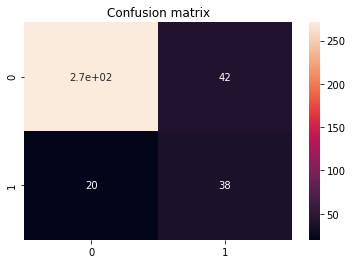

In [127]:
cm=confusion_matrix(y_test,y_test_pred_best)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")   
plt.show()

Se reajustó el modelo para una variedad de combinaciones de valores específicos para cada uno de los hiperparámetros. Se ajustaron 70 modelos diferentes, y se identificó el mejor modelo a aquel que tiene los siguientes parámetros:

- alpha': 0.001,
- 'penalty': 'l1',
- 'loss': 'hinge'

En comparación con el modelo estimado empleando los parámetros por default, podríamos decir que los resultados que obtenemos son levemente mejores: ahora el modelo predice mejor la clase minoritaria. 

Sin embargo, para este caso práctico hemos establecido que se deberían reducir los FN, es decir, aquellas predicciones para las cuales el modelo a predicho que el cliente no caerá en default pero en realidad si lo hará (cuadrante inferior izquierdo). En este caso, tomando un umbral del 50%, los FN se han reducido. Podemos encontrar el umbral de probabilidad "optimo" a traves de la curva ROC, utilizando el ïndice de Youden.

Al establecer el loss='hinge', se utiliza una clasificación de máximo margen, utilizada en SVM.
Para graficar la curva ROC se deberá utilizar la función predict_proba para obtener las probabilidades de cada clase. Sin embargo, esta funcionalidad no esta disponible con el loss='hinge', para lo cual deberíamos cambiar este parámetro reduciendo así la performance del modelo.

Se utilizará por lo tanto la función decision_function, que básicamente encuentra los hiperplanos separando el espacio entre dos areas asociadas con la clasificación. Dado un punto, esta función encuentra la distancia a los separadores.


In [133]:
Image(url= "https://www.researchgate.net/profile/Jose-A-Seoane/publication/258103353/figure/fig1/AS:601637525651456@1520452972225/The-argument-inside-the-decision-function-of-a-classifier-is-w-A-x-th-b-The-separating.png")

Al no tener las probabilidades, los umbrales devueltos por la función roc_auc no son probabilidades sino "distancias" 

In [186]:
threshold,roc_df=encontrar_punto_corte_roc(y_test, best_model.decision_function(X_test))
print("El umbral óptimo es : {:.6f}".format(threshold[0]))

El umbral óptimo es : -0.208925


In [224]:
roc_df[roc_df.threshold==threshold[0]]

,tpr,fpr,tf,threshold
46,0.775862,0.226837,0.002699,-0.208925


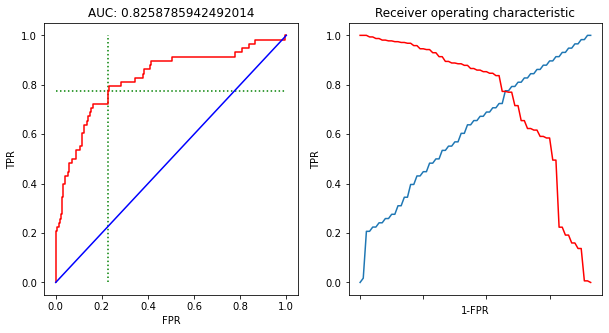

In [188]:
plot_roc_auc(y_test,  best_model.decision_function(X_test) ,0.775862,0.226837)

In [218]:
X_test_predicciones=X_test.reset_index(drop=True)
X_test_predicciones['predicciones']=best_model.decision_function(X_test)
X_test_predicciones.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,predicciones
0,4200,50216.0,58541.0,19.0,0.0,0.0,209.871302,0.0,19.0,20.208033,-1.641663
1,19300,50554.0,76140.0,9.0,2.0,0.0,78.276625,3.0,27.0,36.026904,1.248928
2,13000,78766.0,106450.0,6.0,0.0,0.0,107.951312,0.0,26.0,24.870994,-1.024786
3,11800,67678.0,108092.0,13.0,0.0,7.0,126.658232,0.0,36.0,37.162690,4.027847
4,87500,55938.0,86794.0,15.0,0.0,0.0,223.881040,0.0,16.0,36.753653,-1.536803


In [220]:
X_test_predicciones['prediccion']=X_test_predicciones['predicciones'].apply(lambda x: 1 if x>threshold[0] else 0 )
X_test_predicciones

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,predicciones,prediccion
0,4200,50216.0,58541.0,19.0,0.0,0.0,209.871302,0.0,19.0,20.208033,-1.641663,0
1,19300,50554.0,76140.0,9.0,2.0,0.0,78.276625,3.0,27.0,36.026904,1.248928,1
2,13000,78766.0,106450.0,6.0,0.0,0.0,107.951312,0.0,26.0,24.870994,-1.024786,0
3,11800,67678.0,108092.0,13.0,0.0,7.0,126.658232,0.0,36.0,37.162690,4.027847,1
4,87500,55938.0,86794.0,15.0,0.0,0.0,223.881040,0.0,16.0,36.753653,-1.536803,0
...,...,...,...,...,...,...,...,...,...,...,...,...
366,79100,23553.0,103807.0,25.0,0.0,1.0,142.193458,0.0,13.0,31.469937,-0.768735,0
367,16300,79087.0,102921.0,23.0,0.0,0.0,256.253084,0.0,45.0,36.987086,-1.378780,0
368,26900,72848.0,101736.0,10.0,0.0,0.0,131.409634,0.0,21.0,36.369027,-0.615816,0
369,13000,80587.0,110064.0,6.0,0.0,0.0,85.009197,1.0,13.0,33.990040,-0.180998,1


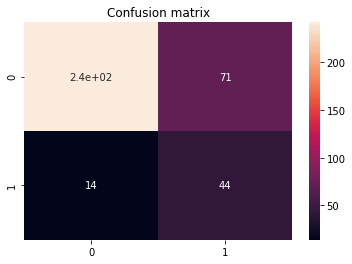

In [221]:
cm=confusion_matrix(y_test,X_test_predicciones.prediccion)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")   
plt.show()

In [222]:
print(classification_report(y_test, X_test_predicciones.prediccion))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       313
           1       0.38      0.76      0.51        58

    accuracy                           0.77       371
   macro avg       0.66      0.77      0.68       371
weighted avg       0.86      0.77      0.80       371



Se ha disminuido la presición del modelo a expensar de aumentar el recall con respecto al modelo anterior, priorizando de esta manera el menor número de FN.

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


#### Ajustamos el modelo

In [318]:
model=DecisionTreeClassifier(random_state=0) 
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

#### Predecimos y obtenemos las métricas

In [319]:
y_train_pred= model.predict(X_train)
y_test_pred=model.predict(X_test)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("TESTEO")
print(classification_report(y_test, y_test_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1232
           1       1.00      1.00      1.00       251

    accuracy                           1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483

TESTEO
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.64      0.63        58

    accuracy                           0.88       371
   macro avg       0.77      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371



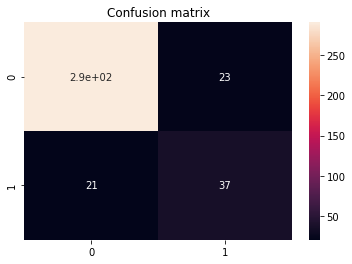

In [320]:
cm=confusion_matrix(y_test,y_test_pred)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")   
plt.show()

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### Definimos una grilla de parámetros

In [321]:
param_grid = {
    "criterion": ["gini", "entropy"],
    'max_depth': [2,3,4,5,10,15,20],
    "min_samples_leaf": [2,3,4,5,10,15,20,25,30],
    "min_samples_split": [2,3,4,5,6,7,8,9,10,15,20]
}

#### Hacemos la validación cruzada con el modelo de descenso de árbol de desición y la grilla de hiperparámetros que queremos probar 

In [322]:
model = DecisionTreeClassifier(random_state=0,class_weight='balanced')

cv = GridSearchCV(model, param_grid, scoring='balanced_accuracy', cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 10, 15, 20],
                         'min_samples_leaf': [2, 3, 4, 5, 10, 15, 20, 25, 30],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15,
                                               20]},
             scoring='balanced_accuracy')

In [323]:
results = cv.cv_results_

In [324]:
df = pd.DataFrame(results)
df[['param_criterion', 'param_max_depth', "param_min_samples_leaf","param_min_samples_split",'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
0,gini,2,2,2,0.696722,0.024519,1248
1,gini,2,2,3,0.696722,0.024519,1248
2,gini,2,2,4,0.696722,0.024519,1248
3,gini,2,2,5,0.696722,0.024519,1248
4,gini,2,2,6,0.696722,0.024519,1248
...,...,...,...,...,...,...,...
1381,entropy,20,30,8,0.703877,0.036641,958
1382,entropy,20,30,9,0.703877,0.036641,958
1383,entropy,20,30,10,0.703877,0.036641,958
1384,entropy,20,30,15,0.703877,0.036641,958


In [325]:
cv.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, random_state=0)

In [326]:
cv.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

#### Evaluamos, predecimos y obtenemos las métricas del mejor modelo obtenido a partir de los datos de entrenamiento y test

In [327]:
best_model=DecisionTreeClassifier(criterion="gini", max_depth=15, min_samples_leaf=2, random_state=0)
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=2, random_state=0)

In [328]:
y_train_pred_best= best_model.predict(X_train)
y_test_pred_best= best_model.predict(X_test)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred_best))

print("TESTEO")
print(classification_report(y_test, y_test_pred_best))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1232
           1       0.99      0.86      0.92       251

    accuracy                           0.98      1483
   macro avg       0.98      0.93      0.95      1483
weighted avg       0.98      0.98      0.98      1483

TESTEO
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       313
           1       0.71      0.60      0.65        58

    accuracy                           0.90       371
   macro avg       0.82      0.78      0.80       371
weighted avg       0.90      0.90      0.90       371



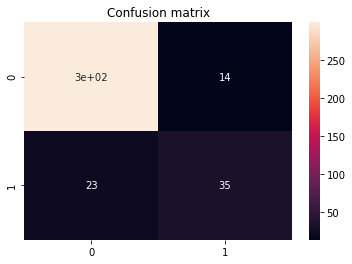

In [329]:
cm=confusion_matrix(y_test,y_test_pred_best)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")
plt.show()

De la comparación entre las dos matrices de confusión se desprende que en el mejor modelo encontrado se redujeron la cantidad de casos correctamente clasificados dentro de la clase 1 (default) así como también los erróneamente clasificados dento de la clase 0. Es decir, se redujeron los casos eran clasificados como no default, pero que se correspondían con clientes que estaban en default. Esto último constituía el objetivo de la búsqueda del mejor modelo: uno tal que redujera la mala clasificación de aquellos clientes que entraran en default. 
En contraste, aumentaron los casos erróneamiente clasificados dentro de la clase 1 y los correctamente clasificados dentro de la clase 0.

La diferencia entre el modelo por default y el obtenido con GridSearch está en el parámetro max_depth, que es uno de los indicadores de complejidad en los árboles de decisión. El valor predeterminado es None, el árbol sigue creciendo hasta que los nodos son "puros", sobreajustando. 

Graficaremos la curva ROC para encontrar el umbral óptimo de probabilidad utilizando el modelo con los parámetros por default.

In [331]:
model=DecisionTreeClassifier(random_state=0) 
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [332]:
threshold,roc_df=encontrar_punto_corte_roc(y_test, model.predict_proba(X_test)[:,1])
print("El umbral óptimo es : {:.6f}".format(threshold[0]))

El umbral óptimo es : 1.000000


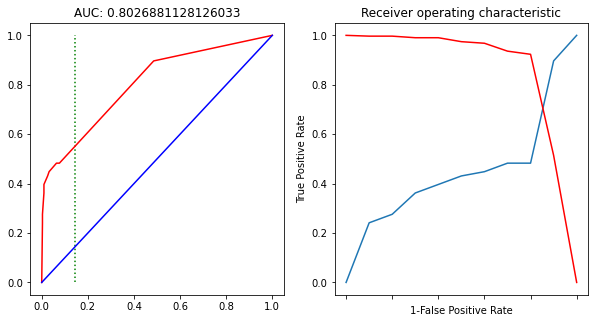

In [53]:
plot_roc_auc(y_test, best_model.predict_proba(X_test),threshold[0])

In [ ]:
X_test_predicciones=X_test.copy()
X_test_predicciones['pred_proba']=model.predict_proba(X_test_predicciones)[:,1]

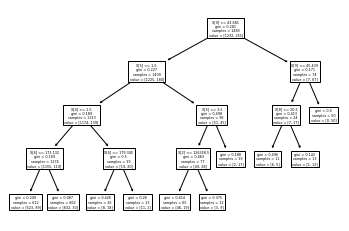

In [29]:
plot_tree(best_model);

Se reajustó el modelo para una variedad de combinaciones de valores específicos para cada uno de los hiperparámetros. Se ajustaron 17 modelos diferentes, y se identificó el mejor modelo a aquel que tiene los siguientes parámetros:


- 'criterion': 'gini', 
- 'max_depth': 15, 
- 'min_samples_leaf': 10


En comparación con el modelo estimado empleando los parámetros por default, podríamos establecer que el último modelo mejora las predicciones ya que nos permite reducir el error en la predicción de los clientes de la clase 1 (default).
Asimismo, a partir de la comparación entre los modelos de descenso de gradientes y árbol de decisión, podríamos establecer que el último ofrece mejores predicciones. 